# Forward encoding model based on Pim Mostert Decoding toolbox



In [1]:
!pwd

/Users/junjieji/Desktop/master-thesis


In [2]:
import sys
import time as tic
# %matplotlib qt
from scipy.io import loadmat
import numpy as np
import pandas as pd
import mat73

import inspect #path_fun = inspect.getfile(StratifiedKFold)
import matplotlib.pyplot as plt
import DecToolbox as dt
import mne
import os
import random

from statsmodels.tsa.stattools import coint


In [3]:
path_utils = '/decoding_toolbox_py/helper_funcs' 
sys.path.append(path_utils)

# Variables

In [4]:
''' VARIABLES '''

dataset = 'eeg'

amount_of_subjects = 26

numC = 8

angles = [i * 180./numC for i in range(numC)]

x_labels = np.array(angles)

resample = False # speeds up the procees but showing worse results overall
resample_frequency = 20 # in Hz, original freq is 500Hz

cfg_stim = dict()
cfg_stim['kappa'] = 4
cfg_stim['NumC'] = numC
cfg_stim['Tuning'] = 'vonmises'
# cfg_stim['Tuning'] = 'halfRectCos'
cfg_stim['offset'] = 0

cfg_train = dict()
cfg_train['gamma'] = 0.1
cfg_train['demean'] = True
cfg_train['returnPattern'] = True

cfg_test = dict()
cfg_test['demean'] = 'traindata'

# Loading & preparing orientation data

In [5]:
from toolbox.methods import train_main_ori, read_data

all_epochs, all_rawdata = read_data(amount_of_subjects= amount_of_subjects,
                        task='main',
                        resample=resample,
                        resample_frequency=20
                        )
read_st = False
if read_st:
    all_st_rawdata = read_data(task='stim')
    stim_cols = all_st_rawdata[0]['metadata'].columns
    stim_shape = all_st_rawdata[0]['epoch_dat'].shape
ori = ['o1', 'o2', 'o3', 'o4', 'o5', 'o6']

In [6]:
time_labels = all_epochs[0].times # The labels are the same for all subjects
main_cols = all_rawdata[0]['metadata'].columns
main_shape = all_rawdata[0]['epoch_dat'].shape
# print(all_rawdata[0]['metadata'][ori[1]])
print(main_shape, main_cols)

(250, 32, 2876) Index(['index', 'subj', 'nblock', 'ntrial', 'nrep', 'trial_type', 'cond-1',
       'cond', 'rDV', 'DV', 'resp', 'deci-2', 'deci-1', 'deci', 'corr-1',
       'r_map', 'correct', 'confi', 'RT', 'd1', 'conf_lvl', 'correct-1', 'd2',
       'd3', 'd4', 'd5', 'd6', 'o1', 'o2', 'o3', 'o4', 'o5', 'o6', 'confi-1',
       'conf_lvl-1'],
      dtype='object')


# Procedure for multisubject

In [7]:
prt = all_rawdata[0]['metadata']['o6']
# print(np.unique(prt))
print(np.min(prt), np.max(prt))

0.003 3.14


In [8]:
'''17 min for 1 orientation, estimate 2 hours for all 6 :)'''
'''1 min for 1 ori if resample = True, 6 min for all 6 '''
amount_of_orientations = 6
Xhat_centeredmean = [None]*amount_of_orientations
for i in range(amount_of_orientations):
    print('Working on orientation: ', i+1)
    Xhat_centeredmean[i]= train_main_ori(all_rawdata, use_orientation=i)

Working on orientation:  1
Working on orientation:  2
Working on orientation:  3
Working on orientation:  4
Working on orientation:  5
Working on orientation:  6


In [9]:
print(time_labels)

[-0.5   -0.498 -0.496 ...  5.246  5.248  5.25 ]


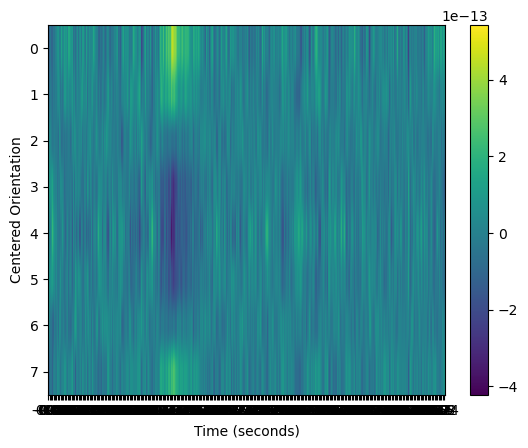

In [10]:
import matplotlib.pyplot as plt

plt.imshow(Xhat_centeredmean[0], aspect='auto')
plt.colorbar()
# Set the X-axis tick locations and labels
step = 10  # Display every x labels
plt.xticks(range(0, len(time_labels), step), time_labels[::step])
plt.xlabel('Time (seconds)')
plt.ylabel('Centered Orientation')
plt.show()



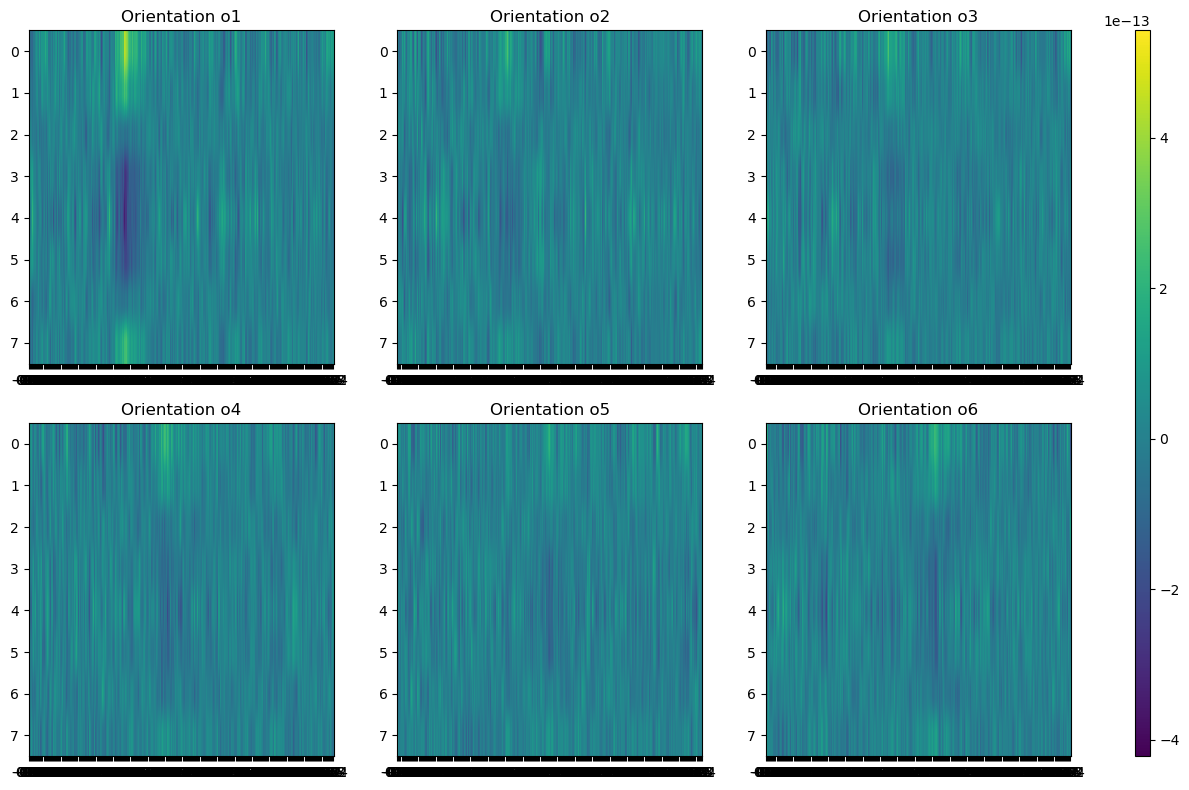

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec

fig = plt.figure(figsize=(12, 8))
gs = gridspec.GridSpec(2, 4, width_ratios=[1, 1, 1, 0.05])

# Compute the global minimum and maximum values for the color scale
min_val = np.min(Xhat_centeredmean)
max_val = np.max(Xhat_centeredmean)

for i in range(6):
    ax = fig.add_subplot(gs[i // 3, i % 3])
    im = ax.imshow(Xhat_centeredmean[i], 
                   aspect='auto', 
                   vmin=min_val, vmax=max_val)
    ax.set_title(f'Orientation o{i+1}')
    ax.set_xticks(range(0, len(time_labels), step))
    step = 10  # Display every x labels
    ax.set_xticklabels(time_labels[::step])

# Add a colorbar outside the plot
cbar_ax = fig.add_subplot(gs[:, -1])
cbar = fig.colorbar(im, cax=cbar_ax)

plt.tight_layout()
plt.show()


In [12]:
print(np.shape(Xhat_centeredmean))
Zhat = np.mean(Xhat_centeredmean,axis=0)
print(np.shape(Zhat))


(6, 8, 2876)
(8, 2876)


### Mean for all the values

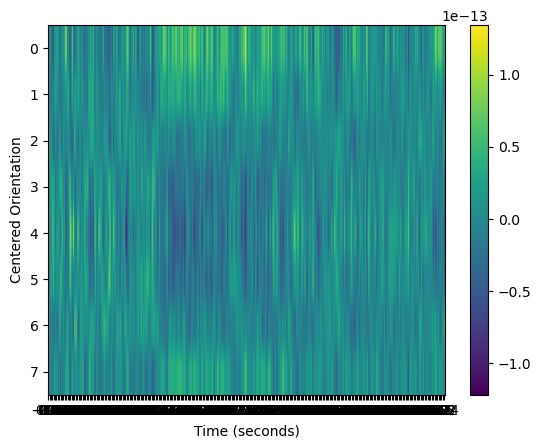

In [13]:
import matplotlib.pyplot as plt

plt.imshow(Zhat, aspect='auto')
plt.colorbar()
# Set the X-axis tick locations and labels
step = 10  # Display every x labels
plt.xticks(range(0, len(time_labels), step), time_labels[::step])
plt.xlabel('Time (seconds)')
plt.ylabel('Centered Orientation')
plt.show()


# Using repetitions

In [14]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

max_abs = np.max(np.abs(Xhat_centeredmean_rep))

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

im0 = axes[0].imshow(Xhat_centeredmean_rep[0], aspect='auto', vmin=-max_abs, vmax=max_abs)
axes[0].set_title('Repetition 0')

im1 = axes[1].imshow(Xhat_centeredmean_rep[1], aspect='auto', vmin=-max_abs, vmax=max_abs)
axes[1].set_title('Repetition 1')

im2 = axes[2].imshow(Xhat_centeredmean_rep[2], aspect='auto', vmin=-max_abs, vmax=max_abs)
axes[2].set_title('Repetition 2')

divider = make_axes_locatable(axes[2])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im2, cax=cax)

plt.tight_layout()
plt.show()



NameError: name 'Xhat_centeredmean_rep' is not defined

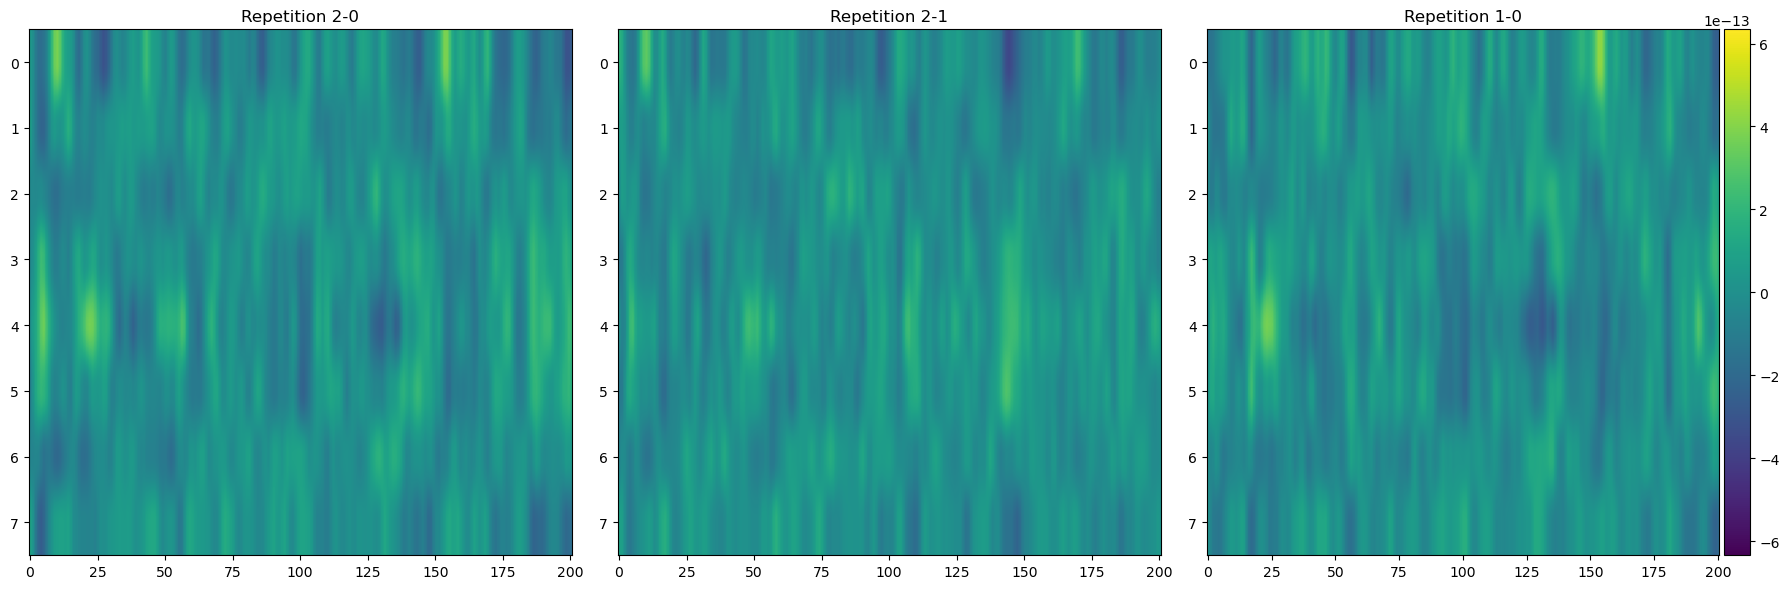

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

im0 = axes[0].imshow(Xhat_centeredmean_rep[2] - Xhat_centeredmean_rep[0], aspect='auto', vmin=-max_abs, vmax=max_abs)
axes[0].set_title('Repetition 2-0')

im1 = axes[1].imshow(Xhat_centeredmean_rep[2] - Xhat_centeredmean_rep[1], aspect='auto', vmin=-max_abs, vmax=max_abs)
axes[1].set_title('Repetition 2-1')

im2 = axes[2].imshow(Xhat_centeredmean_rep[1] - Xhat_centeredmean_rep[0], aspect='auto', vmin=-max_abs, vmax=max_abs)
axes[2].set_title('Repetition 1-0')

divider = make_axes_locatable(axes[2])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im2, cax=cax)

plt.tight_layout()
plt.show()


In [ ]:
stophere

NameError: name 'stophere' is not defined

In [ ]:


'''

Cluster based simulation, buscarlo en mne

'''

'''

Clasificar reponse (quizas no sale)

clasificar actividad motora (si que sale)

6 min de loc
main task
6 min de loc

MAIN TASK son 6 stimulos, long ts. 

'''


https://en.wikipedia.org/wiki/Pearson_correlation_coefficient

# crossmodal